In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import numpy as np
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
path_to_save = '../paper/figures/inference_generalizability/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

In [21]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def barplot_custom(df, category='Cell Type',
                   sub_category='Type', value='R2_mean',
                   error='R2_std', xlabel=None, ylabel=None, title=None, save=False):
    """ Plot bar from report of R^2 values. Inspired by scGen plots."""
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_palette("deep")
    plt.figure(figsize=[7,7])
    names = df[category].unique()
    n = len(names)
    sub = df[sub_category].unique()
    n_sub = len(sub)
    xpos = np.arange(0,n_sub*n, n_sub)
    for i,gr in enumerate(sub):
        sub_df = df[df[sub_category] == gr]
        plt.bar(xpos + i/1.25, sub_df[value], capsize=10, alpha=0.95, label=f"{gr}", yerr=sub_df[error], error_kw=dict(lw=1, capsize=4, capthick=0.5))
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(xpos+(0.375*(n_sub-1)), names, rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([0,1])
    if title:
        plt.title(title, fontsize=15)
    if n_sub > 1:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    #plt.show()
    if save:
        plt.savefig(save, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    return

In [3]:
# Reload data
adata_kang = sc.read('../data/kang_pbmc.h5ad')
vega.utils.setup_anndata(adata_kang)

Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 18868 cells, 6998 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [4]:
dir_ctout = '../trained_models/vega_ct_out/'
vae_all = vega.VEGA.load('../trained_models/kang_vega/')

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.


## Intra-dataset generalizability (biological)

In [5]:
# Initialize Empty R2 matrices
r2_in_ct = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))
r2_out_ct = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))
prop_top50_ct = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))
pathway_list = vae_all.adata.uns['_vega']['gmv_names']
for i,cell_type in enumerate(adata_kang.obs['cell_type'].unique()):
    print('Running for %s cells'%(cell_type))
    # Reload best model fold
    vae_out = vega.VEGA.load(dir_ctout+'vega_kang_pbmc_%s_out/'%(cell_type))
    adata_ct = adata_kang.copy()[adata_kang.obs['cell_type'] == cell_type,:].copy()
    vega.utils.setup_anndata(adata_ct)
    adata_ct_stim = adata_kang.copy()[((adata_kang.obs['cell_type'] == cell_type) & (adata_kang.obs['condition'] == 'stimulated'))].copy()
    adata_ct_stim.X = adata_ct_stim.X.A
#     adata_ct_ctrl = adata_kang.copy()[((adata_kang.obs['cell_type'] == cell_type) & (adata_kang.obs['condition'] == 'control'))].copy()
#     adata_ct_ctrl.X = adata_ct_ctrl.X.A
    # k times re-sampling of 2000 cells and compute R^2
    for k in range(100):
        stim_sample = adata_ct_stim[np.random.choice(np.arange(len(adata_ct_stim)), 2000),:].copy()
        X_stim_sample = stim_sample.X
        # Encode/Decode
        X_all = vae_all.generative(adata=stim_sample, use_mean=True)
        X_out = vae_out.generative(adata=stim_sample, use_mean=True)
        # Differential factor expression
        vae_all.differential_activity(adata=adata_ct,
                                      groupby='condition',
                                      group1='stimulated',
                                      group2='control',
                                      n_samples=5000,
                                      use_permutations=True,
                                      n_permutations=10000,
                                      random_seed=0)
        top50_all = pathway_list[np.argsort(np.abs(adata_ct.uns['_vega']['differential']['stimulated vs.control']['bayes_factor']))[::-1][:50]]
        vae_out.differential_activity(adata=adata_ct,
                                      groupby='condition',
                                      group1='stimulated',
                                      group2='control',
                                      n_samples=5000,
                                      use_permutations=True,
                                      n_permutations=10000,
                                      random_seed=0)
        top50_out = pathway_list[np.argsort(np.abs(adata_ct.uns['_vega']['differential']['stimulated vs.control']['bayes_factor']))[::-1][:50]]
        r2_X_all = np.corrcoef(np.average(X_all, axis=0), np.average(X_stim_sample, axis=0))[0,1]**2
        r2_X_out = np.corrcoef(np.average(X_out, axis=0), np.average(X_stim_sample, axis=0))[0,1]**2
        # Fill matrix
        r2_in_ct[k,i] = r2_X_all
        r2_out_ct[k,i] = r2_X_out
        prop_top50_ct[k,i] = len(set(top50_all).intersection(set(top50_out)))/float(50)

Running for NK cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1304 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for Dendritic cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1192 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for CD4T cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6198 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for B cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2033 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for FCGR3A+Mono cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4022 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for CD14+Mono cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2882 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for CD8T cells
Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1237 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


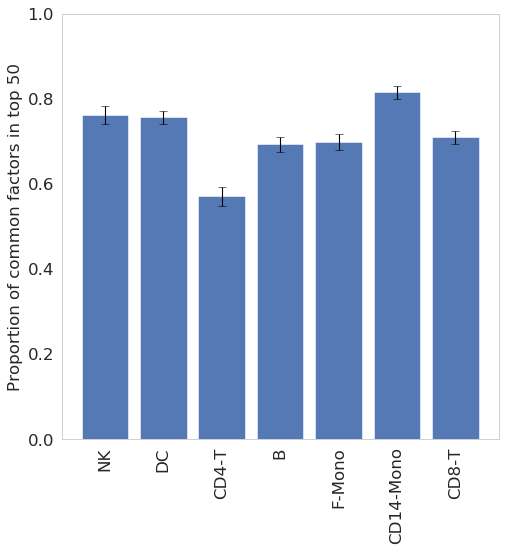

In [23]:
dict_rename = {'NK':'NK','Dendritic':'DC', 'CD4T':'CD4-T', 'CD8T':'CD8-T', 'B':'B', 'FCGR3A+Mono':'F-Mono', 'CD14+Mono':'CD14-Mono'}
df_top50_ct = pd.DataFrame({'R2_mean':np.average(prop_top50_ct, axis=0),
                            'R2_std':np.std(prop_top50_ct, axis=0),
                            'Cell Type':adata_kang.obs['cell_type'].map(dict_rename).unique(),
                            'Type':['z']*prop_top50_ct.shape[1]})
barplot_custom(df_top50_ct, xlabel=None,
               ylabel=r'Proportion of common factors in top 50', #save=False)
              save=path_to_save+'gen_top50_intra.pdf')

In [19]:
df_top50_ct['R2_mean'].mean()

0.7149714285714287

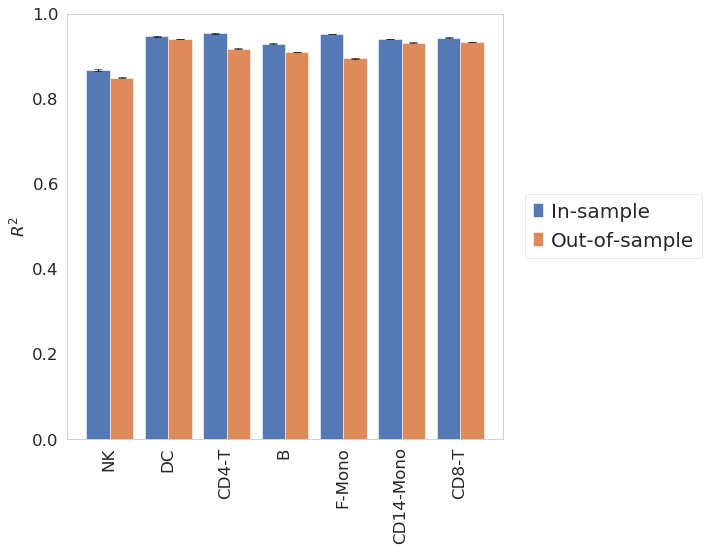

In [24]:
df_X_intra = pd.DataFrame({'R2_mean':np.concatenate((np.average(r2_in_ct, axis=0),np.average(r2_out_ct, axis=0))),
                            'R2_std':np.concatenate((np.std(r2_in_ct, axis=0),np.std(r2_out_ct, axis=0))),
                            'Cell Type':np.concatenate((adata_kang.obs['cell_type'].map(dict_rename).unique(),adata_kang.obs['cell_type'].map(dict_rename).unique())) ,
                            'Type':['In-sample']*r2_in_ct.shape[1] + ['Out-of-sample']*r2_out_ct.shape[1]})
barplot_custom(df_X_intra, sub_category='Type', xlabel=None, ylabel=r"$R^2$", #save=False)
              save=path_to_save+"gen_r2_intra.pdf")

### Inter-dataset generalizibility (technical)

In [10]:
adata_zheng = sc.read('../../data/zheng_3k_hvg.h5ad')
vega.utils.setup_anndata(adata_zheng)
rename_dict = {'CD4 T cells':'CD4T', 'B cells':'B', 'CD14+ Monocytes':'CD14+Mono', 'NK cells':'NK', 'CD8 T cells':'CD8T',
                         'FCGR3A+ Monocytes':'FCGR3A+Mono', 'Dendritic cells':'Dendritic'}
adata_zheng.obs['cell_type'] = adata_zheng.obs['cell_type'].map(rename_dict)

Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2623 cells, 6998 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [11]:
r2_X_study_A = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))
r2_X_study_B = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))
r2_X_real = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))

for i,cell_type in enumerate(adata_kang.obs['cell_type'].unique()):
    print('Running for %s cells'%(cell_type))
    adata_kang_ctrl = adata_kang.copy()[((adata_kang.obs['cell_type'] == cell_type) & (adata_kang.obs['condition'] == 'control'))].copy()
    adata_kang_stim = adata_kang.copy()[((adata_kang.obs['cell_type'] == cell_type) & (adata_kang.obs['condition'] == 'stimulated'))].copy()
    adata_zheng_ctrl = adata_zheng.copy()[adata_zheng.obs['cell_type'] == cell_type].copy()
    adata_kang_ctrl.X = adata_kang_ctrl.X.A
    adata_kang_stim.X = adata_kang_stim.X.A
    adata_zheng_ctrl.X = adata_zheng_ctrl.X.A
    for k in range(100):
        kang_sample = adata_kang_ctrl[np.random.choice(np.arange(len(adata_kang_ctrl)), 2000),:].copy()
        X_kang_sample = kang_sample.X
        zheng_sample = adata_zheng_ctrl[np.random.choice(np.arange(len(adata_zheng_ctrl)), 2000),:].copy()
        X_zheng_sample = zheng_sample.X
        #z_kang = vae_all.to_latent(kang_sample, return_mean=True)
        #z_zheng = vae_all.to_latent(zheng_sample, return_mean=True)
        X_kang_rec = vae_all.generative(kang_sample, use_mean=True)
        X_zheng_rec = vae_all.generative(zheng_sample, use_mean=True)
        # Correlations
        r2_X_kang = np.corrcoef(np.average(X_kang_rec, axis=0), np.average(X_kang_sample, axis=0))[0,1]**2
        r2_X_zheng = np.corrcoef(np.average(X_zheng_rec, axis=0), np.average(X_zheng_sample, axis=0))[0,1]**2
        #Add to matrices
        r2_X_study_A[k,i] = r2_X_kang
        r2_X_study_B[k,i] = r2_X_zheng
        r2_X_real[k,i] = np.corrcoef(np.average(adata_kang_ctrl.X, axis=0), np.average(adata_zheng_ctrl.X, axis=0))[0,1]**2

Running for NK cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for Dendritic cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for CD4T cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for B cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for FCGR3A+Mono cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for CD14+Mono cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running for CD8T cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


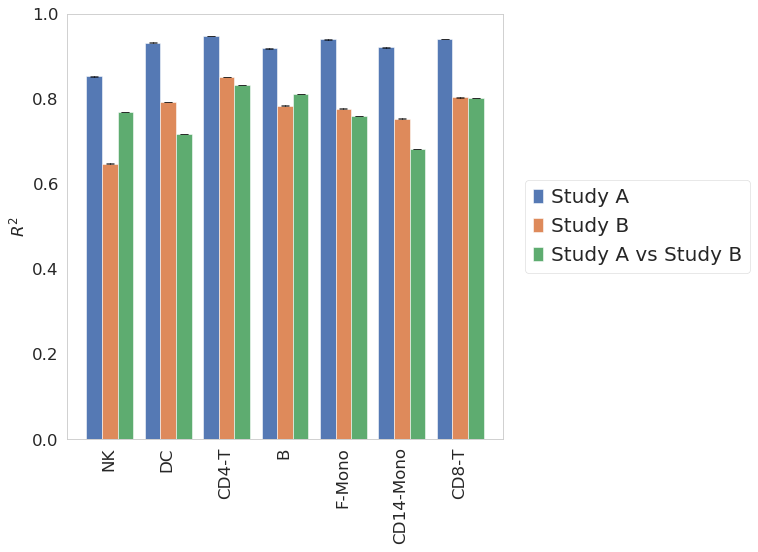

In [25]:
df_X_studies = pd.DataFrame({'R2_mean':np.concatenate((np.average(r2_X_study_A, axis=0),
                                                       np.average(r2_X_study_B, axis=0),
                                                      np.average(r2_X_real, axis=0))),
                            'R2_std':np.concatenate((np.std(r2_X_study_A, axis=0),
                                                     np.std(r2_X_study_B, axis=0),
                                                    np.std(r2_X_real, axis=0))),
                            'Cell Type':np.concatenate((adata_kang.obs['cell_type'].map(dict_rename).unique(),
                                                        adata_kang.obs['cell_type'].map(dict_rename).unique(),
                                                        adata_kang.obs['cell_type'].map(dict_rename).unique())) ,
                            'Type':['Study A']*r2_X_study_A.shape[1] + ['Study B']*r2_X_study_A.shape[1] + ['Study A vs Study B']*r2_X_study_A.shape[1] })
barplot_custom(df_X_studies, sub_category='Type', xlabel=None, ylabel=r"$R^2$", #save=False)
              save=path_to_save+'gen_r2_inter.pdf')

In [13]:
vae_ctrl = vega.VEGA.load('../trained_models/kang_control_vega/')
print(vae_ctrl)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 675, dropout_rate:0.5, z_dropout:0.5, beta:0.0001, positive_decoder:True
Model is trained: True


In [14]:
prop_top50_studies = np.zeros((100,len(adata_kang.obs['cell_type'].unique())))

adata_kang_ctrl = adata_kang.copy()[adata_kang.obs['condition'] == 'control'].copy()
adata_zheng_ctrl = adata_zheng.copy()

for k in range(100):
    vae_ctrl.differential_activity(adata=adata_kang_ctrl, groupby='cell_type',
                                   n_samples=5000, use_permutations=True,
                                   n_permutations=10000, random_seed=0)
    vae_ctrl.differential_activity(adata=adata_zheng_ctrl, groupby='cell_type',
                                   n_samples=5000, use_permutations=True,
                                   n_permutations=10000, random_seed=0)
    
    for i, cell_type in enumerate(adata_kang.obs['cell_type'].unique()):
        res_kang = adata_kang_ctrl.uns['_vega']['differential'][cell_type+' vs.rest']
        res_zheng = adata_zheng_ctrl.uns['_vega']['differential'][cell_type+' vs.rest']
        top50_kang = np.array(pathway_list)[np.argsort(np.abs(res_kang['bayes_factor']))[::-1][:50]]
        top50_zheng = np.array(pathway_list)[np.argsort(np.abs(res_zheng['bayes_factor']))[::-1][:50]]
        prop_top50_studies[k,i] = len(set(top50_kang).intersection(set(top50_zheng)))/float(50)
        

No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_t

No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_type]
No reference group: running 1-vs-rest analysis for .obs[cell_t

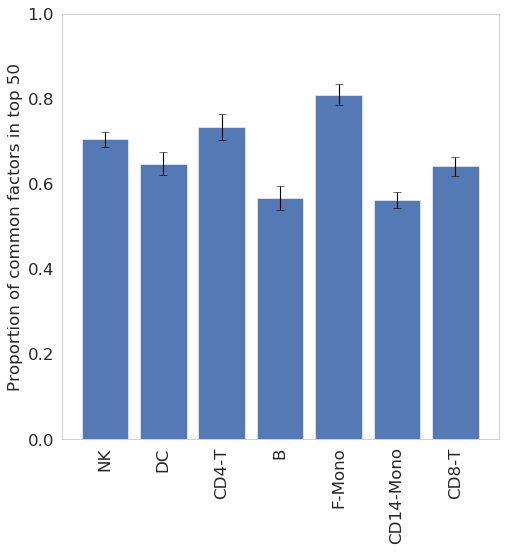

In [26]:
df_top50_studies = pd.DataFrame({'R2_mean':np.average(prop_top50_studies, axis=0),
                            'R2_std':np.std(prop_top50_studies, axis=0),
                            'Cell Type':adata_kang.obs['cell_type'].map(dict_rename).unique(),
                            'Type':['z']*prop_top50_studies.shape[1]})
barplot_custom(df_top50_studies, xlabel=None, ylabel=r'Proportion of common factors in top 50',# save=False)
               save=path_to_save+'gen_top50_inter.pdf')